### 训练一个分类器
**关于数据**

对于图像任务，我们创建了一个包 torchvision，它包含了处理一些基本图像数据集的方法。

这些数据集包括 Imagenet, CIFAR10, MNIST 等。除了数据加载以外，torchvision 还包含了图像转换器， torchvision.datasets 和 torch.utils.data.DataLoader。

torchvision包不仅提供了巨大的便利，也避免了代码的重复。

在这个教程中，我们使用CIFAR10数据集，它有如下10个类别 ：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像都是 3x32x32大小的，即，3颜色通道，32x32像素。

**训练一个图像分类器**
步骤如下：
1. 使用torchvision加载和归一化CIFAR10训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络

**1.读取和归一化CIFAR10**

使用torchvision可以非常容易地加载CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1, 1]的张量。
为什么呢？

In [2]:
classes = ('a', 'b')
cls = ['a', 'b']
print(classes, cls)

('a', 'b') ['a', 'b']


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 frog   dog   cat  frog


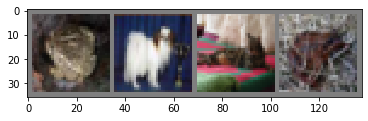

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数
def imshow(img):
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**2.定义一个卷积神经网络**

从神经网络一节复制神经网络代码，并修改输入为3通道图像

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**3.定义损失函数和优化器**

使用交叉熵作为损失函数，使用带动量的随机梯度下降

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

**4.训练网络**
我们只需要在数据迭代器上循环，将数据输入给网络，并优化。

In [12]:
for epoch in range(2): # 多批次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        
        # 梯度置0
        optimizer.zero_grad()
        
        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.108
[1,  4000] loss: 1.967
[1,  6000] loss: 1.959
[1,  8000] loss: 1.952
[1, 10000] loss: 1.943
[1, 12000] loss: 1.936
[2,  2000] loss: 1.951
[2,  4000] loss: 1.931
[2,  6000] loss: 1.941
[2,  8000] loss: 1.922
[2, 10000] loss: 1.948
[2, 12000] loss: 1.958
Finished Training


**5.在测试集上测试网络**

我们在整个训练集上进行了2次训练，但是我们需要检查网络是否从数据集中学习到有用的东西。 通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。 如果预测正确，我们把该样本添加到正确预测列表。 第一步，显示测试集中的图片并熟悉图片内容。

GroundTruth:    cat  ship  ship plane


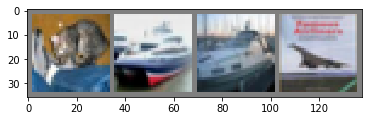

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)

输出是10个标签的能量。 一个类别的能量越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


接下来看看网络在整个测试集上的效果如何

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 27 %


结果看起来不错，至少比随机选择要好，随机选择的正确率为10%，似乎网络学习到了一些东西

在识别哪一类的时候效果好，哪一类不好呢？


In [38]:
class_correct = list((0. for i in range(10)))
class_total = list((0. for i in range(10)))
with torch.no_grad():
    for data in testloader:
        images, lables = data
        outputs = net(images)
        _,predicted = torch.max(outputs, 1)
        c = (predicted == lables).squeeze()
        for i in range(4):
            lable = lables[i]
            class_correct[lable] += c[i].item()
            class_total[lable] += 1

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
         classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 11 %
Accuracy of   car: 16 %
Accuracy of  bird:  5 %
Accuracy of   cat: 46 %
Accuracy of  deer: 39 %
Accuracy of   dog: 18 %
Accuracy of  frog:  3 %
Accuracy of horse: 39 %
Accuracy of  ship: 40 %
Accuracy of truck: 58 %


### 涉及到的Python知识
1.列表：列表类型是一个容器，它里面可以存放任意数量、任意类型的数据。

2.元组：用`()`标识，类似于List（列表），但元组不能二次赋值，相当于只读列表
tuple = ( 'runoob', 786 , 2.23, 'john', 70.2 )

3.列表推导式

4.`%`用于声明后面的占位符
### 其他
1.带momentum（动量）的梯度下降

是梯度下降中常用的一种加速技术。如果上一次的momentum与这一次的负梯度方向是相同的，那这次下降的幅度就会加大，所以这样做能够达到加速收敛的过程。